Please describe your solution in the cell below.

# Solution description
**Overview:** My initial idea was to use both a transfer learning approach and to build my own CNN ensemble and see which performed better. However, I realized that many of the pre-trained models with which I planned to implement transfer learning tended to require some minimum resolution that was too high for the FashionNet images. Because of this, I stuck to making my own CNN ensemble. <br>
**EDA:** I tried a KNN and Random Forest model to get a baseline performance measure. These models achieved an accuracy of 0.85 and 0.88, respectively (see below). <br>
**Preprocessing:** I first reshaped the images for ingestion by the CNN. I then normalized the pixel values by dividing them by 255. I chose this approach over using a standard scaler since the pixel values were not normally distributed. Finally, I one-hot encoded the target variables to make them compatible with the multiclassification task at hand. <br>
**Modeling:** I started with a very thorough CNN with a lot of units in each layer and then took measures to reduce the extent of overfitting (i.e., removing layers and reducing the number of units in each layer). I also tried various combinations of average and max pooling layers, padding settings, and kernel sizes. I varied the extent of dropout layers between both the convolutional and dense layers based on the relationship between the loss and vaidation loss, ultimately settling on the below architecture. The only hyperparameter that I tuned was the learning rate for the Adam optimizer that I used, which I did with a random search. This led to a decent performance increase. Overall, I tweaked this model until I achieved a performance that was substantially better (accuracy = 0.91) than that of the baseline Random Forest (accuracy = 0.88). <br>
**Ensemble:** To create the ensemble, I packed the modeling process into functions that allowed me to vary the seed with which the kernel weights were initialized for each of the convolutional and dense layers. I created 10 variations of the CNN that I constructed, which led to an overall accuracy of 0.93 upon predicting on the test set with each model and averaging the results.

# FashionNet

Welcome to the final assignment in this course. It's been a long journey, but you are now ready to unleash the powers of neural networks at any task. In this assignment, we will be working with a collection of apparel and accessories images. Big online retailers routinely have to classify images provided by third-parties. Your task is to build a neural network that can classify theese images into one of 10 classes with the highest possible accuracy, and document your model's salient properties.

This assignment can be divided into the following sections:
1. downloading data
2. exploratory data analysis
3. data preprocessing
4. building and training
5. saving the model and predictions

In [2]:
import pandas as pd
pd.set_option('precision', 2)
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
%config InlineBackend.figure_format = 'retina'

# Step 1: Download Data

The dataset is has been split into train (49k), validate (7k), test (7k), score (7k) segments.
No other data preprocessing was applied.

In [36]:
%%capture

prefix = 'https://danylo-ucla.s3-us-west-2.amazonaws.com/storage/fashion/jobs/download_and_split/20191024-150318_75375ac5cd151ff751c2cd6dede05681'

# Feature variables for train, validate, and test segments
train_x = pd.read_parquet(f'{prefix}/train_x.parquet')
validate_x = pd.read_parquet(f'{prefix}/validate_x.parquet')
test_x = pd.read_parquet(f'{prefix}/test_x.parquet')

# Target variable to be predicted by the model for each segment
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

# This is the segment which you will be graded on
score_x = pd.read_parquet(f'{prefix}/score_x.parquet')

In [4]:
classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot',
]
classes = pd.DataFrame(
    data={
        'label': classes
    }
)
classes.index.name = 'class_id'
classes

,label
class_id,
0,T-shirt/top
1,Trouser
2,Pullover
3,Dress
4,Coat
5,Sandal
6,Shirt
7,Sneaker
8,Bag


# Step 2: Exploratory Data Analysis

Before building a model, it's a good idea to take a look at the data.
Here are some suggested ideas to explore:
* Display the dataset's shape, mean, value ranges, and other simple statistics.
* Estimate the distribution of classes.
* Calculate baseline model metrics (cross-entropy, accuracy, etc). Without a baseline, there is no meaningful point of reference to measure the success of a model or its attributes. Baseline models can be non-parametric (for this dataset, kNN would be the easiest to build), and parametric (unconditional mean, linear regression, random forest classifier, etc).

(49000, 784)
(49000, 1)
0
255


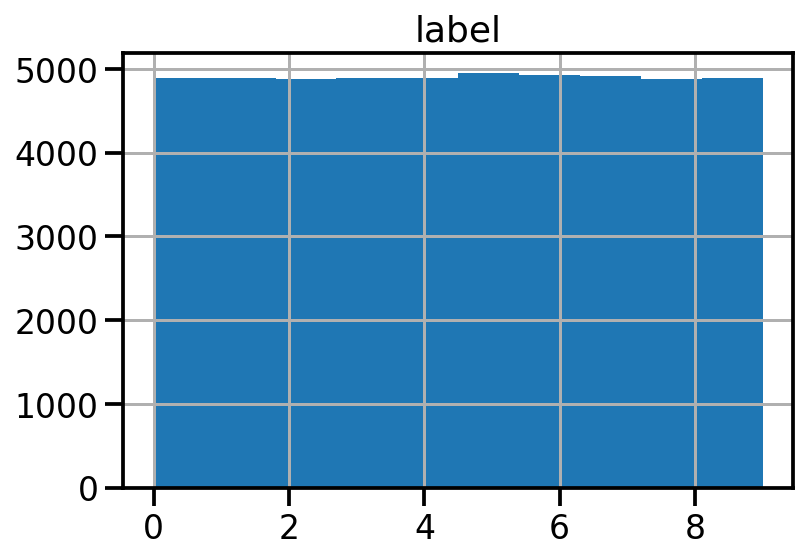

,knn,rf
logloss,1.79,0.40
accuracy,0.85,0.88


In [5]:
# shape of the training dataset
print(train_x.shape) # images are 28 x 28
print(train_y.shape) # labels are 1D, as expected
# min and max values of the pixels
print(train_x.min().min())
print(train_x.max().max()) # so, the pixels have a single value where 0 = white and 1 = black (confirmed below)

# display the distribution of classes
train_y.hist()
plt.show() # classes are evenly distributed across all labels, with ~5000 of each image type

# baseline models
# since these are baseline models, we won't use the validation set to tune hyperparameters
# i.e., we'll just predict on the test set with default parameters to calculate baseline metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score
# fit and evaluate kNN
knn = KNeighborsClassifier()
knn.fit(train_x, train_y.values.ravel())
pred_y_knn_proba = knn.predict_proba(test_x)
ll_knn = log_loss(test_y, pred_y_knn_proba)
pred_y_knn = knn.predict(test_x)
acc_score_knn = accuracy_score(test_y, pred_y_knn)
# fit and evaluate Random Forest
rf = RandomForestClassifier()
rf.fit(train_x, train_y.values.ravel())
pred_y_rf_proba = rf.predict_proba(test_x)
ll_rf = log_loss(test_y, pred_y_rf_proba)
pred_y_rf = rf.predict(test_x)
acc_score_rf = accuracy_score(test_y, pred_y_rf)
# create and display baseline dataframe
baseline_df = pd.DataFrame({'knn':[ll_knn, acc_score_knn],
                            'rf':[ll_rf, acc_score_rf]}, index=['logloss', 'accuracy'])
baseline_df

0
0
0
0
0
0
0
0
0
0


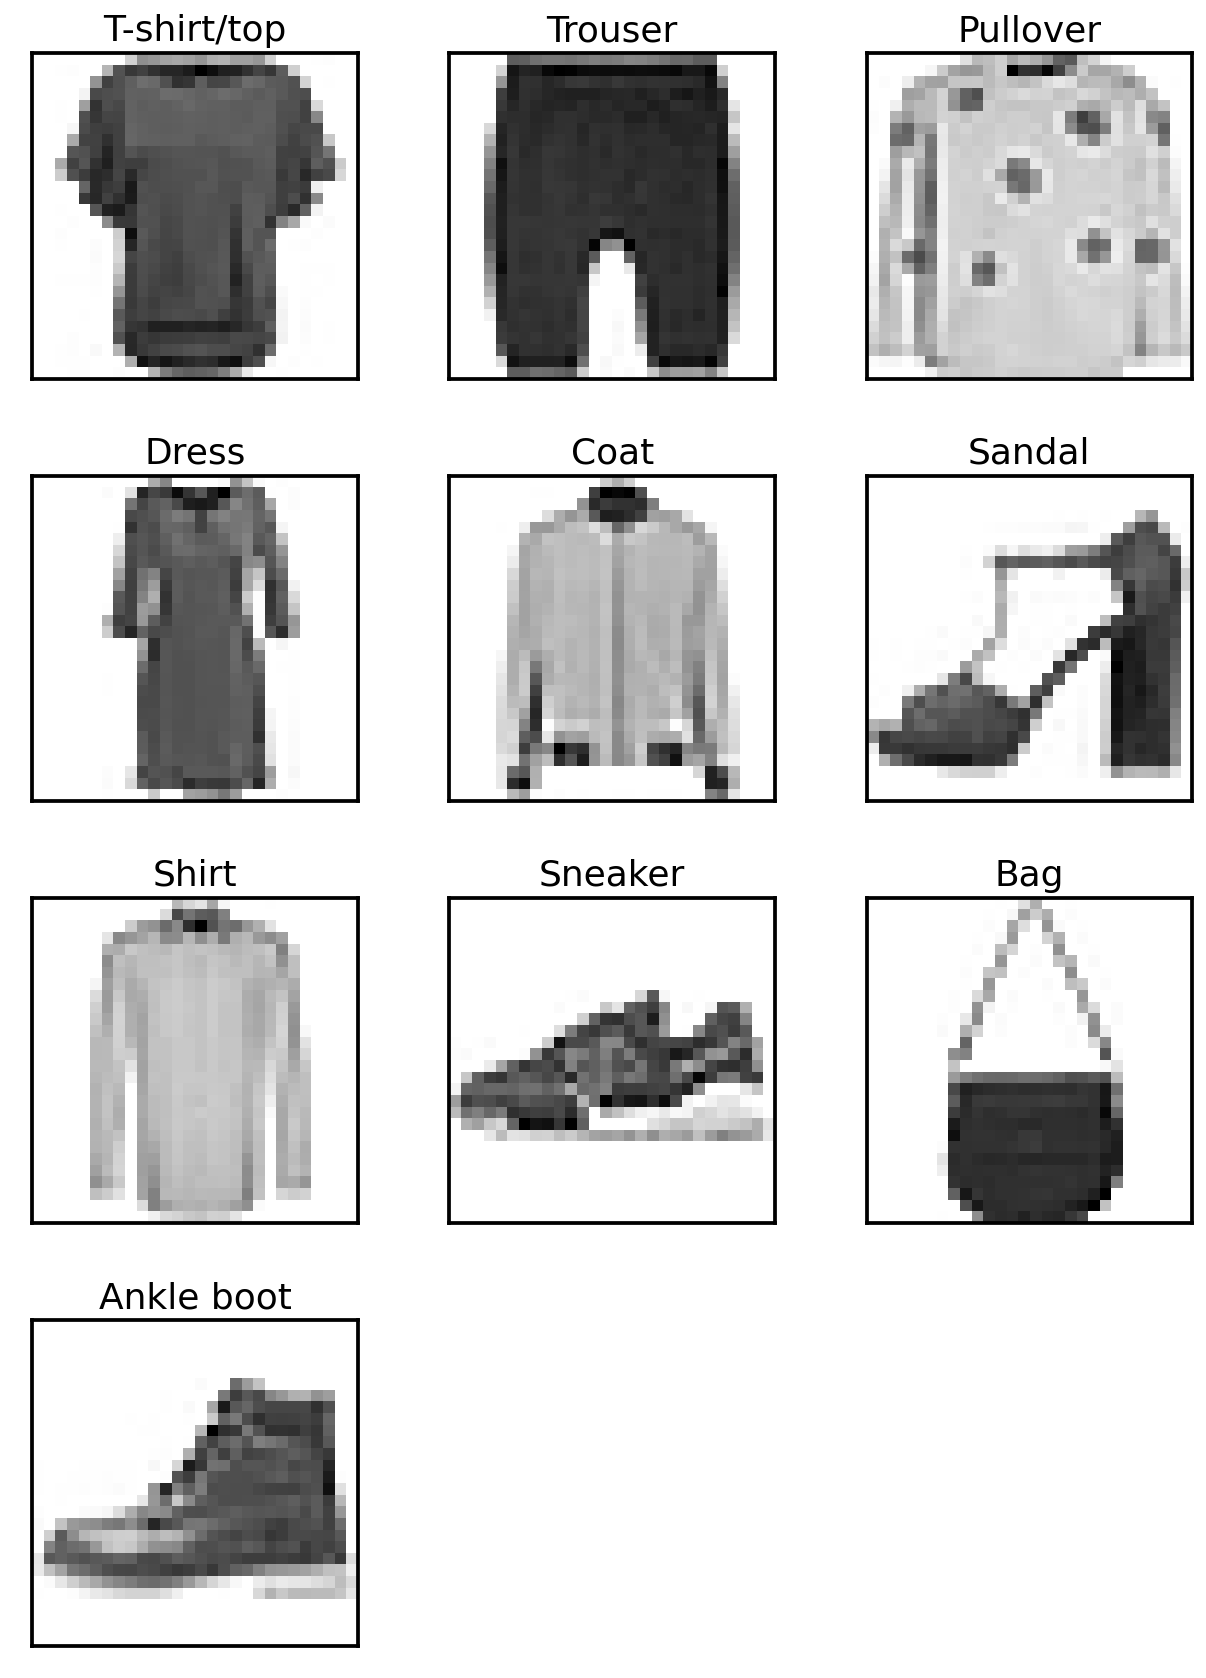

In [6]:
# This cell is plotting a random sample from each class.

n = classes.shape[0]
ncols = 3
nrows = math.ceil(n/ncols)

plt.figure(figsize=[3*ncols, 3*nrows])
for idx, cl in classes['label'].iteritems():
    
    plt.subplot(nrows, ncols, idx+1)
    
    img = train_x.loc[train_y['label'] == idx].sample(1)
    img = img.values.reshape(28, 28)
    
    # display the pixel value of the top left corner of each image
    # these pixels are all white, so we can confirm that 0 = white
    print(img[0][0])
    
    plt.imshow(img, cmap='binary')
    
    plt.title(classes.loc[idx, 'label'])
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()
plt.show()

# Step 3: Data Preprocessing

Next step is to transform the dataset for training. You are free to do any preprocesing that you would like.
Here are some suggestions that might or might not be useful for your model:
* standard scaling of the feature variables
* one-hot-encoding of the target variable
* reshaping the feature variables from 1D to 2D

And relevant documentation:
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
* https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html

(49000, 28, 28, 1)
(7000, 28, 28, 1)
(7000, 28, 28, 1)
(7000, 28, 28, 1)


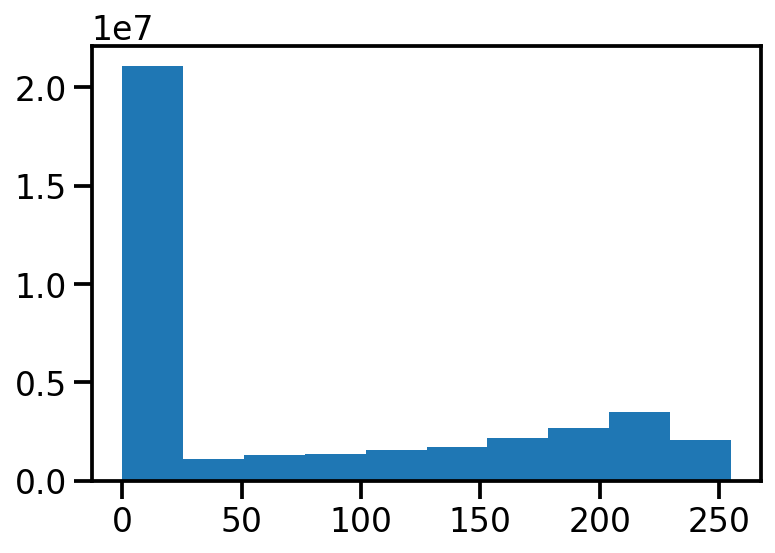

2
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [37]:
# convert images to 2D arrays
import math
img_dim = 28
train_x = train_x.values.reshape(train_x.shape[0], img_dim, img_dim, 1)
validate_x = validate_x.values.reshape(validate_x.shape[0], img_dim, img_dim, 1)
test_x = test_x.values.reshape(test_x.shape[0], img_dim, img_dim, 1)
score_x = score_x.values.reshape(score_x.shape[0], img_dim, img_dim, 1)
# check shapes
print(train_x.shape)
print(validate_x.shape)
print(test_x.shape)
print(score_x.shape)

# display historgram of pixel values
plt.hist(train_x.ravel())
plt.show()

# normalize pixel values by dividing by 255 (this can speed up the training process)
train_x = train_x / 255.0
validate_x = validate_x / 255.0
test_x = test_x / 255.0
score_x = score_x / 255.0

# one-hot encode target variable
from tensorflow.keras.utils import to_categorical
# display first initial training label
print(train_y.loc[0][0])
train_y = to_categorical(train_y)
validate_y = to_categorical(validate_y)
test_y = to_categorical(test_y)
# display first one-hot encoded training label to check one-hot encoding
print(train_y[0])

To make sure everything was properly processed, let's display a few of the images:

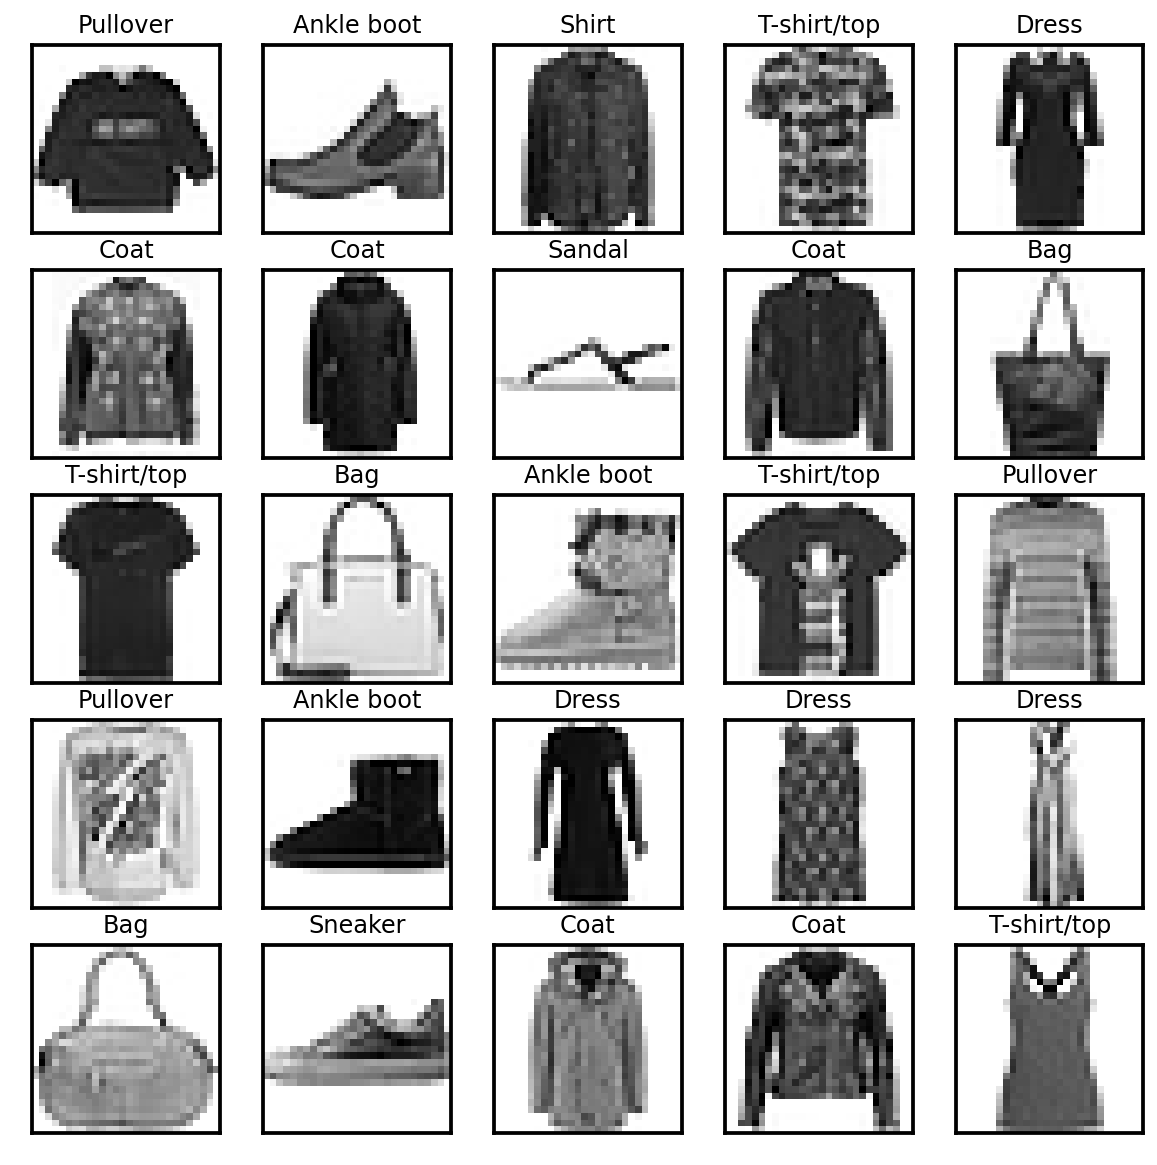

In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_x[i], cmap=plt.cm.binary)
    plt.title(classes.loc[np.where(train_y[i] == 1)].values[0][0], fontsize=12)
plt.show()

# Step 4: Building and training

Here comes the most challenging part. Are you ready to unleash the power of neural networks?
You can refer to the slides and discussion in the first lecture on hyperparameter optimization, random search, and greedy search.

While I'd like to leverage transfer learning and combine various pre-trained models into an ensemble, the resolution (28x28) of these images is too low for many of the models available (e.g., VGG16, InceptionV3, ResNet50, etc.). Because of this, we'll stick to constructing our CNN from scratch and then build the ensemble model by varying the random state from which the weights are initialized.

In [9]:
# we first configure the GPU to be used by Tensorflow
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2021-10-29 21:58:47.040433: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-29 21:58:47.070206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 21:58:47.070999: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-29 21:58:47.071285: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-10-29 21:58:47.073093: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-10-29 21:58:47.074868: I tensorflow/stream_executor/platform/defaul

The below architecture yielded an accuracy score (~0.89) better than that of the baseline models with a learning rate of 0.01. With this in mind, we'll implement a random search across a range of learning rates near this value to see if we can further improve the performance prior to implementing the ensemble.

In [28]:
# Enter your code here.
# You can add cells directly below this one too.

from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.initializers import GlorotUniform

def build_cnn(hp: HyperParameters, seed=11):

    # we'll first try the ensemble with the same architecture but vary the random initialization
    model = tf.keras.models.Sequential([
        # Conv2D/Pooling layers
        tf.keras.layers.Conv2D(256, kernel_size=3, padding='same', activation='relu', kernel_initializer=GlorotUniform(seed=seed)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu', kernel_initializer=GlorotUniform(seed=seed+100)),
        tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', kernel_initializer=GlorotUniform(seed=seed+200)),
        tf.keras.layers.AvgPool2D(pool_size=(2, 2), padding='same'),
        tf.keras.layers.Flatten(),
        # fully connected classifier layers + dropout layers
        tf.keras.layers.Dense(64, activation='relu', kernel_initializer=GlorotUniform(seed=seed+300)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu', kernel_initializer=GlorotUniform(seed=seed+400)),
        tf.keras.layers.Dense(16, activation='relu', kernel_initializer=GlorotUniform(seed=seed+500)),
        # output layer has 10 units since there are 10 classes, multiclass classification --> softmax activation
        tf.keras.layers.Dense(units=10, activation='softmax', kernel_initializer=GlorotUniform(seed=seed+600))
    ])

    # compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float(name='learning_rate', min_value=0.005, max_value=0.05, sampling='log'),
        ),
        loss='categorical_crossentropy'
    )
    
    return model

def train_cnn(model, seed, epochs=50, patience=5):

    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    # fit the model
    history = model.fit(
        train_x, train_y,
        epochs=epochs,
        batch_size=128,
        validation_data=(validate_x, validate_y),
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=patience)]
    )
    
    return history

In [11]:
from kerastuner.tuners import RandomSearch

tuner = RandomSearch(
    build_cnn,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='cnn_hyperop',
    
    # experiment name must change upon modifying the model structure or the set of hyperparameters
    project_name = 'cnn_01'
)

# This displays which hyperparameters are tunable, and their respective distribution.
tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project cnn_hyperop/cnn_01/oracle.json


2021-10-29 21:59:05.232335: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2021-10-29 21:59:05.256923: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2300005000 Hz
2021-10-29 21:59:05.257284: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x555a8abf8e20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-10-29 21:59:05.257311: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-10-29 21:59:05.257782: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 21:59:05.258587: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tes

INFO:tensorflow:Reloading Tuner from cnn_hyperop/cnn_01/tuner0.json
Search space summary
Default search space size: 1
learning_rate (Float)
{'default': 0.005, 'conditions': [], 'min_value': 0.005, 'max_value': 0.05, 'step': None, 'sampling': 'log'}


In [11]:
# we now run the random search
np.random.seed(11)
tf.random.set_seed(11)

tuner.search(
    train_x, train_y,
    epochs=10, # lower number of epochs for the search (increase on final training pass)
    batch_size=128,
    shuffle=True,
    validation_data=(validate_x, validate_y)
)

Trial 10 Complete [00h 06m 09s]
val_loss: 0.3125696579615275

Best val_loss So Far: 0.25705381234486896
Total elapsed time: 01h 01m 28s
INFO:tensorflow:Oracle triggered exit


In [12]:
tuner.results_summary()

Results summary
Results in cnn_hyperop/cnn_01
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
learning_rate: 0.005059757909463998
Score: 0.25705381234486896
Trial summary
Hyperparameters:
learning_rate: 0.005573086694096593
Score: 0.2617170810699463
Trial summary
Hyperparameters:
learning_rate: 0.006561662899494251
Score: 0.27867574493090314
Trial summary
Hyperparameters:
learning_rate: 0.007385612638555972
Score: 0.28284503022829693
Trial summary
Hyperparameters:
learning_rate: 0.009052866711791877
Score: 0.3125696579615275
Trial summary
Hyperparameters:
learning_rate: 0.01962417081715121
Score: 0.40527238448460895
Trial summary
Hyperparameters:
learning_rate: 0.01630828329040531
Score: 1.0256934364636738
Trial summary
Hyperparameters:
learning_rate: 0.025059785912437904
Score: 1.691709707180659
Trial summary
Hyperparameters:
learning_rate: 0.026732317832726695
Score: 1.6951921085516612
Trial summary
Hyperparameters:
learning_rate: 0.0

In [13]:
# display trial info
pd.DataFrame([
    {
        'trial_id': t.trial_id,
        'score': t.score,
        **t.hyperparameters.values 
    }
    for t in tuner.oracle.get_best_trials(num_trials=10)
]).set_index('trial_id')

,score,learning_rate
trial_id,,
557d95a670b85883edcc9d750d6f062f,0.26,5.06e-03
64459126ba66f41526bf62cfa9600699,0.26,5.57e-03
81edf0371399bdda22e09525a9d5a9a9,0.28,6.56e-03
fa8b3aef73cbe53ddcf18b03aa29fd7f,0.28,7.39e-03
67540cdef15df76e6c3b16046949bc8c,0.31,9.05e-03
7870751be491054744dc41f7c14e8ac1,0.41,1.96e-02
e9f844b95ca85f6784f67ee3bbd60728,1.03,1.63e-02
12e3717082b575007c8d1271c6f2a029,1.69,2.51e-02
02b79bdc1a811be401c1a112c4f940eb,1.70,2.67e-02


In [14]:
# display optimal learning rate
best_hyperparameters = tuner.get_best_hyperparameters()[0]
best_hyperparameters.values

{'learning_rate': 0.005059757909463998}

In [12]:
# now, a final training pass with the optimal learning rate
hp = HyperParameters()
hp.Fixed('learning_rate', value=0.005059757909463998)
cnn = build_cnn(hp)
history = train_cnn(cnn, seed=11, epochs=100, patience=2)

Epoch 1/100


2021-10-29 21:59:36.733765: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-10-29 21:59:36.908099: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


383/383 [==============================] - 13s 34ms/step - loss: 0.7446 - val_loss: 0.4543
Epoch 2/100
383/383 [==============================] - 12s 32ms/step - loss: 0.4669 - val_loss: 0.3733
Epoch 3/100
383/383 [==============================] - 12s 32ms/step - loss: 0.3966 - val_loss: 0.3433
Epoch 4/100
383/383 [==============================] - 12s 32ms/step - loss: 0.3540 - val_loss: 0.3060
Epoch 5/100
383/383 [==============================] - 12s 32ms/step - loss: 0.3286 - val_loss: 0.2853
Epoch 6/100
383/383 [==============================] - 12s 32ms/step - loss: 0.3022 - val_loss: 0.2841
Epoch 7/100
383/383 [==============================] - 12s 32ms/step - loss: 0.2918 - val_loss: 0.2796
Epoch 8/100
383/383 [==============================] - 12s 32ms/step - loss: 0.2738 - val_loss: 0.2571
Epoch 9/100
383/383 [==============================] - 12s 32ms/step - loss: 0.2626 - val_loss: 0.2546
Epoch 10/100
383/383 [==============================] - 12s 32ms/step - loss: 0.2560 

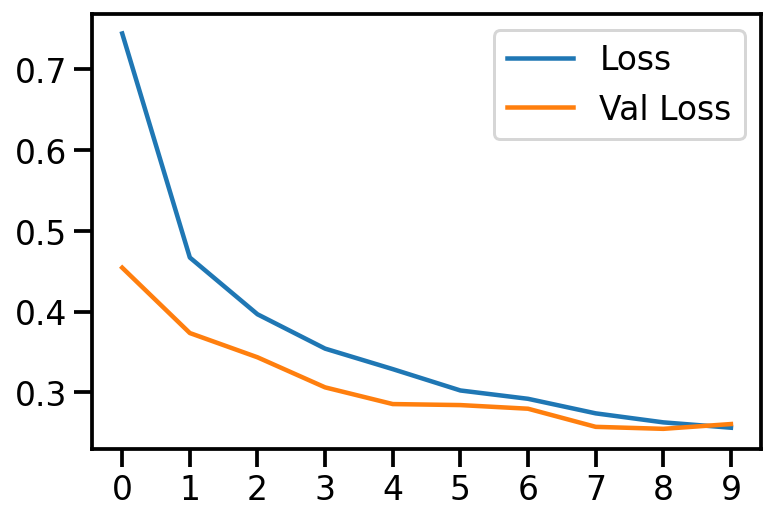

In [13]:
# display learning curve of final model
lcurve_loss = pd.Series(history.history['loss'])
lcurve_val_loss = pd.Series(history.history['val_loss'])
plt.plot(lcurve_loss, label='Loss')
plt.plot(lcurve_val_loss, label='Val Loss')
plt.legend()
plt.xticks(lcurve_loss.index)
plt.show()

In [14]:
# compute log loss and accuracy
proba_y = cnn.predict(test_x)
print(f'{log_loss(test_y, proba_y):.2f}')
pred_y = to_categorical((proba_y).argmax(axis=-1))
print(f'{accuracy_score(test_y, pred_y):.2f}')

0.27
0.91


The CNN is substantially outperforming the baseline models. We'll now implement the ensemble by constructing the above model multiple times with different random states, predicting on the test set with each version, and averaging the outputs.

In [29]:
# function to combine the model building and training process
def build_train_cnn(seed):
    model = build_cnn(hp, seed=seed)
    train_cnn(model, seed, epochs=100, patience=2) # optimal arguments determined via single CNN above
    return model

# set ensemble size, initialize list in which ensemble constituents will be stored
n_ensemble = 10
# accumulate models
cnns = [build_train_cnn(seed=seed) for seed in range(n_ensemble)]

Epoch 1/100
383/383 [==============================] - 12s 32ms/step - loss: 0.7479 - val_loss: 0.4315
Epoch 2/100
383/383 [==============================] - 12s 31ms/step - loss: 0.4210 - val_loss: 0.3244
Epoch 3/100
383/383 [==============================] - 12s 31ms/step - loss: 0.3521 - val_loss: 0.3244
Epoch 4/100
383/383 [==============================] - 12s 32ms/step - loss: 0.3197 - val_loss: 0.2951
Epoch 5/100
383/383 [==============================] - 12s 32ms/step - loss: 0.2948 - val_loss: 0.2923
Epoch 6/100
383/383 [==============================] - 12s 31ms/step - loss: 0.2801 - val_loss: 0.2592
Epoch 7/100
383/383 [==============================] - 12s 32ms/step - loss: 0.2690 - val_loss: 0.2575
Epoch 8/100
383/383 [==============================] - 12s 31ms/step - loss: 0.2532 - val_loss: 0.2520
Epoch 9/100
383/383 [==============================] - 13s 33ms/step - loss: 0.2430 - val_loss: 0.2652
Epoch 10/100
383/383 [==============================] - 12s 32ms/step - l

In [38]:
# predict on test set with each model
probas_y = np.array([cnn_mod.predict(test_x) for cnn_mod in cnns])
# average predictions across all models
probas_y = probas_y.mean(axis=0)
# compute log loss and accuracy
print(f'{log_loss(test_y, probas_y):.2f}')
preds_y = to_categorical((probas_y).argmax(axis=-1))
print(f'{accuracy_score(test_y, preds_y):.2f}')

0.22
0.93


The ensemble has improved the overall predictions, as expected.

# Step 5: Saving the model and predictions

Save your predictions on the Score segment as a Pandas data frame into a variable named `score_y_hat`.

The expected shape of the submitted data frame is `(7000, 10)`, where each column is the probability for each class. The sum of probabilities have to add up to 1. The order of the column has to match the `classes` data frame defined above.

Finally, the data frame needs to have string column names in order to be saved as a Parquet file. If you convert a NumPy array to Pandas data frame, column names will be integers, but you can replace the columns names. There was a similar example of this in the notebook from the first assignment.

In order to verify that your score_y_hat has the right shape and column names,
you can run the following cell.

In [55]:
# predict on score set with each model
score_y_hat = np.array([cnn_mod.predict(score_x) for cnn_mod in cnns])
# average predictions across all models
score_y_hat = score_y_hat.mean(axis=0)
# ensure that probabilities add up to 1
sums = score_y_hat.sum(axis=1)
print(len(sums))
print(np.sum(sums))
# fix column names
score_y_hat = pd.DataFrame(score_y_hat, columns=classes['label'])
# confirm shape and column names
score_y_hat.shape, score_y_hat.columns

7000
7000.0


((7000, 10),
 Index(['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
        'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
       dtype='object', name='label'))

In [60]:
score_y_hat

label,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
0,4.44e-01,1.91e-03,1.07e-01,2.83e-02,1.04e-02,7.83e-04,3.81e-01,3.15e-04,2.62e-02,5.43e-04
1,3.89e-01,1.56e-05,2.63e-03,2.34e-03,6.50e-04,3.14e-07,6.06e-01,1.03e-06,1.23e-04,4.16e-07
2,9.49e-07,1.00e+00,5.15e-06,2.00e-06,1.77e-05,3.65e-10,4.12e-07,2.89e-11,2.00e-08,8.64e-13
3,9.80e-01,2.82e-06,1.87e-03,2.98e-04,4.39e-06,2.79e-06,1.74e-02,3.88e-09,2.35e-05,4.48e-07
4,8.40e-04,4.21e-07,9.76e-01,2.60e-04,8.40e-03,4.01e-05,1.47e-02,4.45e-07,2.26e-05,7.30e-06
...,...,...,...,...,...,...,...,...,...,...
6995,9.89e-01,5.66e-06,1.73e-03,6.44e-04,1.24e-05,5.61e-06,9.03e-03,9.96e-09,2.54e-05,1.30e-06
6996,1.23e-02,1.01e-04,3.63e-02,3.49e-03,3.35e-02,2.46e-06,9.13e-01,1.27e-06,1.05e-03,2.22e-06
6997,3.21e-08,2.90e-14,9.94e-10,5.90e-13,9.67e-12,1.70e-09,9.73e-11,1.06e-09,1.00e+00,4.64e-09
6998,9.59e-03,5.04e-05,4.56e-04,3.38e-04,8.18e-04,7.83e-05,5.83e-03,3.62e-05,9.83e-01,1.98e-04


In [61]:
# Once you are ready to make the graded submission,
# run the model on the score segment,
# and save the results as a Parquet file:

import os 
model_dir = 'fashionnet_model'
os.makedirs(model_dir, exist_ok=True)

score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')

# Next, let's save the model's definition (pack this step into a loop since we have multiple models)
import json
for i,cnn in enumerate(cnns):
    
    with open(f'{model_dir}/keras_model_{i+1}.json', 'w') as f:
        f.write(json.dumps(json.loads(cnn.to_json()), indent=True))

    # Finally, let's save the learned parameters.
    cnn.save_weights(f"{model_dir}/keras_parameters_{i+1}.h5")

# You now have the following files to be submitted:
# 1. This notebook and any other Python code you used to train the final model.
# 2. keras_model.json -- the model's definition
# 3. keras_parameters.json -- the model's trained parameters
# 4. score_y_hat.parquet - the model's output on the score dataset